## Importing

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve,confusion_matrix

import os

import sys

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

In [2]:
import tensorflow
tensorflow.random.set_seed(42)

In [3]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

In [4]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [5]:
# Data Class
import DataClass 
from DataClass import Data
# read prepared data
data = Data( 0, "", "",parquet_path)

## Hybrid model class

In [6]:
class HybridModel:
  def __init__(self,models_path, X_train_seq,X_test_seq, itemized_train_data,itemized_test_data,y_train,y_test,num_sensors):
    self.models_path = models_path
    # input data and label data
    self.X_train_seq=X_train_seq
    self.X_test_seq=X_test_seq
    self.itemized_train_data=itemized_train_data
    self.itemized_test_data=itemized_test_data
    # Define the input shape for the CNN
    self.num_sensors=num_sensors
    self.input_shape = (self.X_train_seq.shape[1], self.num_sensors)
    self.y_train=y_train
    self.y_test=y_test

  def build(self):
      # Define the CNN model
      cnn_input = Input(shape=self.input_shape)
      conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
      pool1 = MaxPooling1D(pool_size=2)(conv1)
      conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
      pool2 = MaxPooling1D(pool_size=2)(conv2)
      conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
      pool3 = MaxPooling1D(pool_size=2)(conv3)
      conv4 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool3)
      #pool4 = MaxPooling1D(pool_size=2)(conv4)
      dropout = Dropout(0.5)(conv4)
      flatten = Flatten()(dropout)
      cnn_output = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)
      # cnn_output = Dense(128, activation='relu')(flatten)
      cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

      # Define the fully connected model
      fc_input = Input(shape=(self.itemized_train_data.shape[1],))
      concat = Concatenate()([cnn_output, fc_input])
      dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concat)
      dense2 = Dense(32, activation='relu')(dense1)
      fc_output = Dense(1, activation='sigmoid')(dense2)

      self.model = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

      # Compile the model
      optimizer = Adam(learning_rate=0.001)
      self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  def taining(self, validation_split, epochs, batch_size):
      early_stopping = EarlyStopping(monitor='val_loss', patience=5)
      self.history = self.model.fit([self.X_train_seq, self.itemized_train_data], self.y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
     
  def predicting(self):
    self.y_prediction = self.model.predict([self.X_test_seq, self.itemized_test_data])
    return self.y_prediction

  def evaluate(self):    
    loss,accuracy = self.model.evaluate([self.X_test_seq, self.itemized_test_data], self.y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Loss:     {loss}')
  
  def scores(self, y_prediction):
      print(f'Precision:      {precision_score(self.y_test, y_prediction)}')
      print(f"Recall:         {recall_score(self.y_test, y_prediction)}")
      print(f"F1:             {f1_score(self.y_test, y_prediction)}")
      print(f"Accuracy:       {accuracy_score(self.y_test, y_prediction)}")
      tn, fp, fn, tp = confusion_matrix(self.y_test, y_prediction, normalize='pred' ).ravel()
      print(f"True Negative:  {tn}")
      print(f"False Positive: {fp}")
      print(f"False Negative: {fn}")
      print(f"True Positive:  {tp}")

  def summary(self):
    print(self.model.summary())

  def plot_model(self,file_name):
    plot_model(self.model, to_file=self.models_path+file_name, show_shapes=True,show_layer_names=True)
     
  def loss_plot(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

  def accuracy_plot(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

  def save_model(self, file_name):
    # save the model
    self.model.save(self.models_path+file_name)

  def load_model(self,file_name):
    # Load the model                       
    self.model = keras.models.load_model(self.models_path+file_name)



In [7]:
def scores(y_test, y_prediction):
  print(f'Precision:      {precision_score(y_test, y_prediction)}')
  print(f"Recall:         {recall_score(y_test, y_prediction)}")
  print(f"F1:             {f1_score(y_test, y_prediction)}")
  print(f"Accuracy:       {accuracy_score(y_test, y_prediction)}")
  tn, fp, fn, tp = confusion_matrix(y_test, y_prediction, normalize='pred' ).ravel()
  print(f"True Negative:  {tn}")
  print(f"False Positive: {fp}")
  print(f"False Negative: {fn}")
  print(f"True Positive:  {tp}")


def loss_plot(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def accuracy_plot(history):
  plt.plot(history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Hybrid model 1 (right stances with 3 features)

In [ ]:
# input data and label data
# input data and label data
df = data.scaled_stances_statics_df[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm']]
y = data.scaled_stances_statics_df[[ 'y']]


X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

train_seq=np.array(list(np.asarray(X_train['r_interp'])), dtype=float)
test_seq=np.array(list(np.asarray(X_test['r_interp'])), dtype=float)

num_sensors=1

# Reshape the sequences to be 3-dimensional (samples, timesteps, features)
X_train_seq = np.reshape( train_seq, (train_seq.shape[0],train_seq.shape[1], num_sensors))
X_test_seq = np.reshape( test_seq, (test_seq.shape[0],test_seq.shape[1], num_sensors))


itemized_train_data = X_train.drop('r_interp',axis=1)
itemized_train_data=itemized_train_data.to_numpy()
# itemized_train_data = np.asarray(itemized_train_data[:,:]).astype('float32')
itemized_test_data = X_test.drop('r_interp',axis=1)
itemized_test_data=itemized_test_data.to_numpy()

In [ ]:
type(y_train.iloc[0][0])

numpy.int64

In [ ]:
model_r_3f = HybridModel(models_path, X_train_seq,X_test_seq, itemized_train_data,itemized_test_data,y_train, y_test, num_sensors)
model_r_3f.build()
model_r_3f.taining(0.2, 50, 32)

Epoch 1/50
342/342 [==============================] - 11s 29ms/step - loss: 1.1641 - accuracy: 0.6120 - val_loss: 0.6470 - val_accuracy: 0.6767
Epoch 2/50
342/342 [==============================] - 9s 28ms/step - loss: 0.7756 - accuracy: 0.6152 - val_loss: 0.7384 - val_accuracy: 0.6767
Epoch 3/50
342/342 [==============================] - 8s 23ms/step - loss: 0.6882 - accuracy: 0.6460 - val_loss: 0.6677 - val_accuracy: 0.6767
Epoch 4/50
342/342 [==============================] - 9s 27ms/step - loss: 0.6441 - accuracy: 0.6717 - val_loss: 0.8313 - val_accuracy: 0.6767
Epoch 5/50
342/342 [==============================] - 8s 22ms/step - loss: 0.7220 - accuracy: 0.6658 - val_loss: 0.7959 - val_accuracy: 0.5563
Epoch 6/50
342/342 [==============================] - 10s 28ms/step - loss: 0.6035 - accuracy: 0.6947 - val_loss: 0.5552 - val_accuracy: 0.7052
Epoch 7/50
342/342 [==============================] - 9s 27ms/step - loss: 0.6215 - accuracy: 0.6886 - val_loss: 0.6156 - val_accuracy: 0.68

In [ ]:
model_r_3f.evaluate()

143/143 [==============================] - 3s 22ms/step - loss: 0.3505 - accuracy: 0.8670
Accuracy: 0.8670177459716797
Loss:     0.35047411918640137


In [ ]:
y_prediction =model_r_3f.predicting()
y_prediction[y_prediction <= 0.5] = 0.
y_prediction[y_prediction > 0.5] = 1.
model_r_3f.scores(y_prediction)

Precision:      0.891900409706902
Recall:         0.9149692854833495
F1:             0.9032875837855091
Accuracy:       0.8670177748518763
True Negative:  0.809971098265896
False Positive: 0.10809959029309801
False Negative: 0.19002890173410406
True Positive:  0.891900409706902


In [ ]:
model_r_3f.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 98, 32)       128         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 49, 32)      0           ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 47, 64)       6208        ['max_pooling1d_3[0][0]']        
                                                                                            

In [ ]:
model_r_3f.plot_model('HybridModel_r_3f.png')

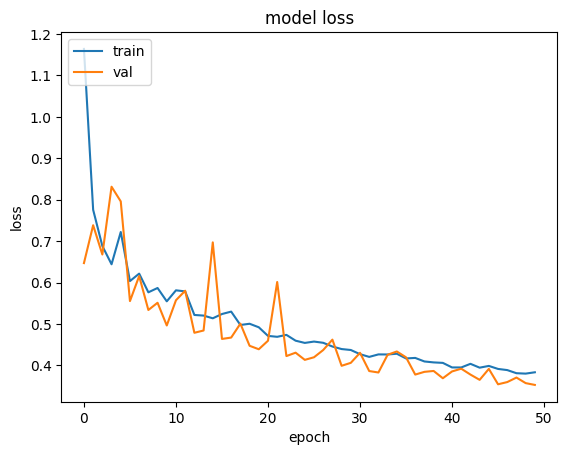

In [ ]:
model_r_3f.loss_plot()

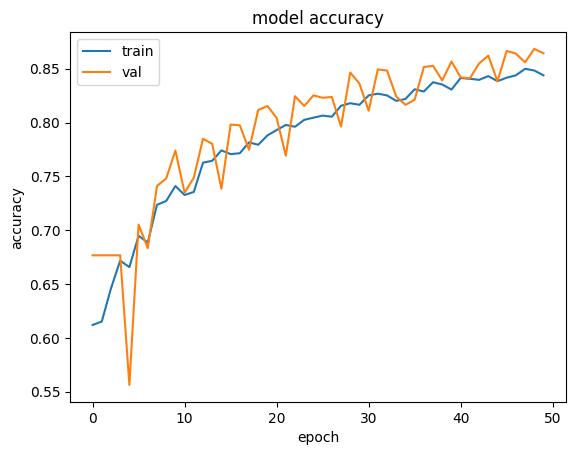

In [ ]:
model_r_3f.accuracy_plot()

### Trying saving 
did not work - the random state is not fixed

In [ ]:
model_r_3f.save_model('hybridmodel_r_3f')

In [ ]:
m = HybridModel(models_path, X_train_seq,X_test_seq, itemized_train_data,itemized_test_data,y_train, y_test, num_sensors)
m.load_model('hybridmodel_r_3f')

In [ ]:
m.evaluate()

143/143 [==============================] - 1s 7ms/step - loss: 1.6595 - accuracy: 0.3037
Accuracy: 0.30370858311653137


### Trying saving weights
did not work - the random state is not fixed

In [ ]:
model_r_3f.model.save_weights(models_path+"hybridmodel_r_3f_weights.h5")
loaded_model = HybridModel(models_path, X_train_seq,X_test_seq, itemized_train_data,itemized_test_data,y_train, y_test, num_sensors)
loaded_model.define()
optimizer = Adam(learning_rate=0.001)
loaded_model.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
loaded_model.model.load_weights(models_path+"hybridmodel_r_3f_weights.h5")
loaded_model.evaluate()

143/143 [==============================] - 2s 10ms/step - loss: 1.6595 - accuracy: 0.3037
Accuracy: 0.30370858311653137


## Splitting train test for all the following models' inputs

In [33]:
df = data.scaled_stances_statics_df.drop(['ID','y','level'],axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

## Hybrid model 2 (right stances with 6 features)

In [34]:
X_train_2=X_train[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel']]
X_test_2= X_test [[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel']]

In [35]:
num_sensors=1

train_seq_2=np.array(list(np.asarray(X_train_2['r_interp'])), dtype=float)
test_seq_2=np.array(list(np.asarray(X_test_2['r_interp'])), dtype=float)

# Reshape the sequences to be 3-dimensional (samples, timesteps, features)
X_train_seq_2 = np.reshape( train_seq_2, (train_seq_2.shape[0],train_seq_2.shape[1], num_sensors))
X_test_seq_2 = np.reshape( test_seq_2, (test_seq_2.shape[0],test_seq_2.shape[1], num_sensors))

train_features_2 = X_train_2.drop('r_interp',axis=1)
train_features_2=train_features_2.to_numpy()

test_features_2 = X_test_2.drop('r_interp',axis=1)
test_features_2=test_features_2.to_numpy()

In [ ]:
input_shape = (X_train_seq_2.shape[1], num_sensors)
feature_input_shape=(train_features_2.shape[1],)

# Define the CNN model
cnn_input = Input(shape=input_shape)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
conv4 = Conv1D(filters=512, kernel_size=3, activation='relu')(pool3)
dropout = Dropout(0.5)(conv4)
#pool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(dropout)
cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
# cnn_output = Dense(128, activation='relu')(flatten)
cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Define the fully connected model
fc_input = Input(shape=feature_input_shape)

concat = Concatenate()([cnn_output, fc_input])
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense2 = Dense(64, activation='relu')(dense1)
dropout = Dropout(0.5)(dense2)
dense3 = Dense(32, activation='relu')(dropout)

fc_output = Dense(1, activation='sigmoid')(dense3)

model_r_6f = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_r_6f.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_r_6f = model_r_6f.fit([X_train_seq_2, train_features_2], y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])
     

Epoch 1/50
342/342 [==============================] - 17s 45ms/step - loss: 1.8904 - accuracy: 0.6648 - val_loss: 0.7087 - val_accuracy: 0.6803
Epoch 2/50
342/342 [==============================] - 15s 44ms/step - loss: 0.6725 - accuracy: 0.6927 - val_loss: 0.6306 - val_accuracy: 0.6767
Epoch 3/50
342/342 [==============================] - 15s 44ms/step - loss: 0.6339 - accuracy: 0.6891 - val_loss: 0.6072 - val_accuracy: 0.6767
Epoch 4/50
342/342 [==============================] - 15s 44ms/step - loss: 0.6099 - accuracy: 0.6910 - val_loss: 0.6152 - val_accuracy: 0.6763
Epoch 5/50
342/342 [==============================] - 15s 44ms/step - loss: 0.6052 - accuracy: 0.6918 - val_loss: 0.5869 - val_accuracy: 0.6832
Epoch 6/50
342/342 [==============================] - 15s 44ms/step - loss: 0.6027 - accuracy: 0.6898 - val_loss: 0.5882 - val_accuracy: 0.6767
Epoch 7/50
342/342 [==============================] - 15s 44ms/step - loss: 0.5947 - accuracy: 0.6903 - val_loss: 0.5789 - val_accuracy:

In [ ]:
model_r_6f = HybridModel(models_path, X_train_seq_2,X_test_seq_2, train_features_2,test_features_2,y_train, y_test, num_sensors)
model_r_6f.build()
model_r_6f.taining(0.2, 50, 32)

Epoch 1/50
342/342 [==============================] - 12s 32ms/step - loss: 1.2341 - accuracy: 0.6794 - val_loss: 0.5477 - val_accuracy: 0.7260
Epoch 2/50
342/342 [==============================] - 9s 25ms/step - loss: 0.7304 - accuracy: 0.6787 - val_loss: 0.6295 - val_accuracy: 0.6818
Epoch 3/50
342/342 [==============================] - 11s 31ms/step - loss: 0.6585 - accuracy: 0.6925 - val_loss: 0.6648 - val_accuracy: 0.6931
Epoch 4/50
342/342 [==============================] - 11s 32ms/step - loss: 0.6403 - accuracy: 0.6995 - val_loss: 1.4677 - val_accuracy: 0.6767
Epoch 5/50
342/342 [==============================] - 8s 25ms/step - loss: 0.6507 - accuracy: 0.6904 - val_loss: 0.6933 - val_accuracy: 0.6975
Epoch 6/50
342/342 [==============================] - 10s 30ms/step - loss: 0.6664 - accuracy: 0.6911 - val_loss: 0.5872 - val_accuracy: 0.7275


In [ ]:
y_prediction =model_r_6f.predicting()
y_prediction[y_prediction <= 0.5] = 0.
y_prediction[y_prediction > 0.5] = 1.
model_r_6f.scores(y_prediction)

143/143 [==============================] - 1s 8ms/step
Precision:      0.7407794925451217
Recall:         0.915615906886518
F1:             0.8189705031810296
Accuracy:       0.7252578450735133
True Negative:  0.6444141689373297
False Positive: 0.25922050745487835
False Negative: 0.3555858310626703
True Positive:  0.7407794925451217


## 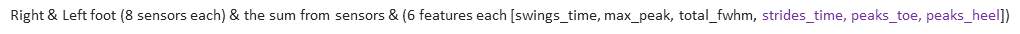

In [6]:
scaled_stances_statics_df=pd.read_parquet(parquet_path+'scaled_stances_statics.gzip')

In [7]:
stance_index = np.arange(1,18227)

In [7]:
scaled_stances_statics_df.shape

(18226, 177)

In [8]:
df_indexed  = scaled_stances_statics_df.insert(3, "stance_index", stance_index, True)

In [9]:
col_lists_9=[]
for col in ["l","r","L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_9.append( col +'_' +  x)

In [10]:
df_temp = scaled_stances_statics_df.explode(col_lists_9)

In [11]:
df_temp=df_temp.fillna(0)

In [ ]:
#df_temp[col_lists_9].isnull().values.any()

In [12]:
df_temp['combined'] = [x for x in df_temp[col_lists_9].to_numpy()]

In [13]:
df_temp.shape

(1822600, 179)

In [14]:
stances = df_temp.groupby('stance_index')['combined'].apply(np.array).reset_index(name='stances_points')

In [15]:
type(stances)

pandas.core.frame.DataFrame

In [16]:
stances.to_parquet(parquet_path+'scaled_stances_statics_forHM.gzip')

In [17]:
s = stances['stances_points'].to_numpy()

In [19]:
s = np.asarray(stances["stances_points"])

In [11]:
df = data.scaled_stances_statics_df.drop(['ID','y','level'],axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [8]:
colnames_9=['r_interp','l_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_9.append( col +'_' +  x)

In [30]:
train_features  = X_train.drop(col_lists_9,axis=1)
train_features =train_features.to_numpy()

In [ ]:
num_sensors=18

train_seq =np.array(list(np.asarray(X_train[col_lists_9])), dtype=float)
test_seq =np.array(list(np.asarray(X_test[col_lists_9])), dtype=float)

# Reshape the sequences to be 3-dimensional (samples, timesteps, features)
X_train_seq  = np.reshape( train_seq , (train_seq .shape[0],train_seq .shape[1], num_sensors))
X_test_seq  = np.reshape( test_seq , (test_seq .shape[0],test_seq .shape[1], num_sensors))

train_features  = X_train.drop(col_lists_9,axis=1)
train_features =train_features.to_numpy()

test_features  = X_test.drop(col_lists_9,axis=1)
test_features =test_features.to_numpy()